# **Test de permutación**

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

![Descripción de la imagen](Captura%20de%20pantalla%202024-12-12%20102408.png)

In [3]:
# Datos
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-con-R/' \
      + 'master/datos/AfterSchool.csv'
datos = pd.read_csv(url)
datos = datos[['Treatment', 'Delinq']]
datos = datos.rename(columns={'Treatment': 'grupo', 'Delinq': 'valor'})
datos['grupo'] = np.where(datos['grupo'] == 0, 'control', 'tratamiento')
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356 entries, 0 to 355
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   grupo   356 non-null    object 
 1   valor   356 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.7+ KB


In [6]:
print(f'Cantidad de filas y columnas es : {datos.shape[0], datos.shape[1]}')
print(f'Total de vacios es {datos.isnull().sum().sum()}')

Cantidad de filas y columnas es : (356, 2)
Total de vacios es 0


In [9]:
datos['grupo'].value_counts()

grupo
control        187
tratamiento    169
Name: count, dtype: int64

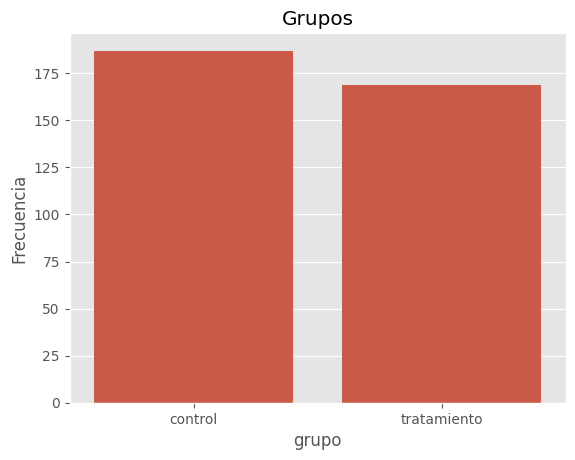

In [13]:
sns.countplot(data=datos,x='grupo')
plt.title('Grupos')
plt.ylabel('Frecuencia')
plt.show()

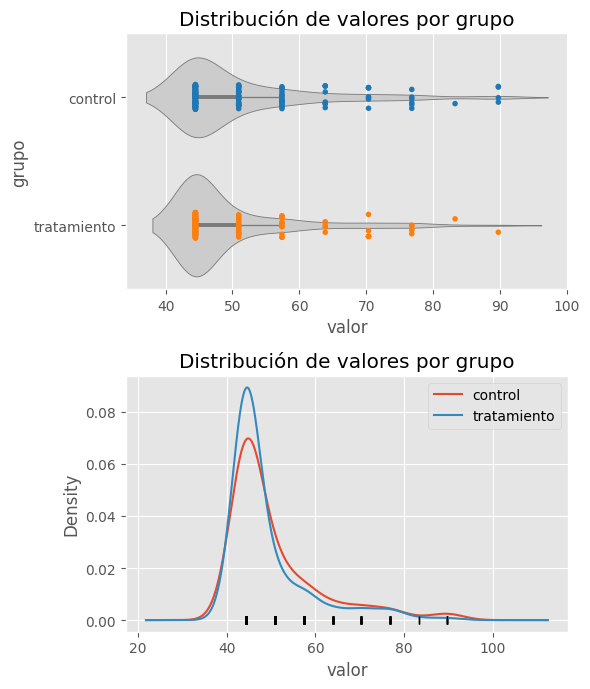

In [14]:
# Gráficos distribución observada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 7))
sns.violinplot(
    x     = datos.valor,
    y     = datos.grupo,
    color = ".8",
    ax    = axs[0]
)
sns.stripplot(
    x    = datos.valor,
    y    = datos.grupo,
    data = datos,
    size = 4,
    jitter  = 0.1,
    palette = 'tab10',
    ax = axs[0]
)
axs[0].set_title('Distribución de valores por grupo')
axs[0].set_ylabel('grupo')
axs[0].set_xlabel('valor');

for grupo in datos.grupo.unique():
    datos_temp = datos[datos.grupo == grupo]['valor']
    datos_temp.plot.kde(ax=axs[1], label=grupo)
    axs[1].plot(datos_temp, np.full_like(datos_temp, 0), '|k', markeredgewidth=1)

axs[1].set_title('Distribución de valores por grupo')
axs[1].set_xlabel('valor');
axs[1].legend()

fig.tight_layout()
plt.show()

In [15]:
# Estadistica descriptiva por grupo 
datos.groupby(by='grupo').describe()

valor                                                        \
             count       mean       std        min        25%        50%   
grupo                                                                      
control      187.0  50.725591  10.52089  44.463082  44.463082  44.463082   
tratamiento  169.0  49.018956   8.97423  44.463082  44.463082  44.463082   

                                   
                   75%        max  
grupo                              
control      50.933188  89.753823  
tratamiento  50.933188  89.753823

## **Test de Permutaciones**

In [17]:
def dif_mean(x1,x2):
    estadisticos=np.mean(x1) - np.mean(x2)
    return estadisticos

dif_observada=dif_mean(x1=datos[datos['grupo']=='control']['valor'],
                       x2=datos[datos['grupo']=='tratamiento']['valor'])
print(f"Diferenciada observada : {dif_observada.round(2)}")

Diferenciada observada : 1.71


In [18]:
def permutaciones(x1, x2, fun_estadistico, n_iteraciones=9999):
    '''
    Función para calcular el valor del estadístico en múltiples permutaciones
    de dos muestras.
    
    Parameters
    ----------
    x1 : numpy array
         valores de la muestra 1.
         
    x2 : numpy array
         valores de la muestra 2.
 
    fun_estadistico : function
        función que recibe como argumento las dos muestras y devuelve el valor
        del estadístico.
        
    n_iteraciones : int
        número de permutaciones calculadas (default `9999`).
        
    Returns
    -------
    distribuciones: numpy array
        valor del estadístico en cada permutación.
    '''
    
    n_x1 = len(x1)
    n_x2 = len(x2)
    pool_datos = np.hstack((x1, x2))
    
    resulados_permutaciones = np.full(shape=n_iteraciones, fill_value=np.nan)
    
    for i in tqdm(range(n_iteraciones)):
        np.random.shuffle(pool_datos)
        estadistico = fun_estadistico(pool_datos[:n_x1], pool_datos[n_x1:])
        resulados_permutaciones[i] = estadistico
        
    return resulados_permutaciones

In [19]:
dist_permut=permutaciones(
    x1=datos[datos['grupo']=='control']['valor'],
    x2=datos[datos['grupo']=='tratamiento']['valor'],
    fun_estadistico=dif_mean,
    n_iteraciones=9999
)

100%|██████████| 9999/9999 [00:00<00:00, 20444.01it/s]


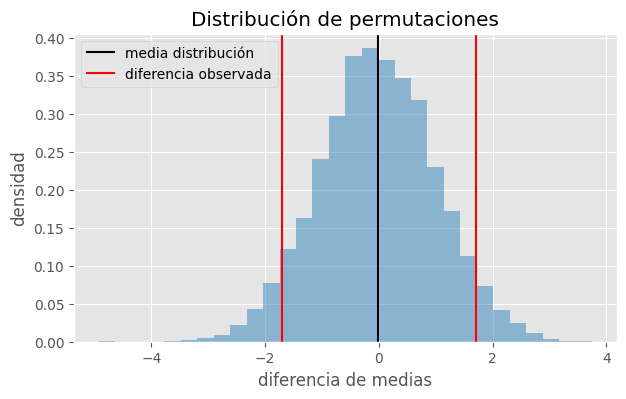

In [20]:
# Distribución de permutaciones
# ==============================================================================
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,4))
ax.hist(dist_permut, bins=30, density=True, color='#3182bd', alpha=0.5)
ax.axvline(x=dist_permut.mean(), color='black', label='media distribución')
ax.axvline(x=dif_observada, color='red', label='diferencia observada')
ax.axvline(x=-dif_observada, color='red')

ax.set_title('Distribución de permutaciones')
ax.set_xlabel('diferencia de medias')
ax.set_ylabel('densidad')
ax.legend()
plt.show()

In [21]:
pd.Series(dist_permut).describe()

count    9999.000000
mean       -0.012196
std         1.029433
min        -4.925822
25%        -0.698541
50%        -0.042584
75%         0.686257
max         3.747392
dtype: float64

In [23]:
# P-value empírico con y sin corrección
# ==============================================================================
p_value = (sum(np.abs(dist_permut) > np.abs(dif_observada)))/len(dist_permut)
p_value_correc = (sum(np.abs(dist_permut) > np.abs(dif_observada)) + 1)/len(dist_permut + 1)
print(f"p-value sin corrección: {p_value.round(4)}")
print(f"p-value con corrección: {p_value_correc.round(4)}")

p-value sin corrección: 0.1033
p-value con corrección: 0.1034


## **Ejemplo 1**

In [ ]:
import numpy as np

# Generar datos de ejemplo
np.random.seed(42)  # Para reproducibilidad
grupo_1 = np.random.normal(loc=5, scale=1, size=30)  # Grupo 1: media = 5
grupo_2 = np.random.normal(loc=6, scale=1, size=30)  # Grupo 2: media = 6

# Calcular la diferencia de medias observada
diferencia_observada = np.mean(grupo_2) - np.mean(grupo_1)

# Concatenar los datos
datos_concatenados = np.concatenate([grupo_1, grupo_2])

# Función para calcular el estadístico bajo permutaciones
def permutacion_test(data, grupo1_size, n_permutaciones=1000):
    diferencia_perm = []
    for _ in range(n_permutaciones):
        np.random.shuffle(data)  # Permutar etiquetas
        perm_grupo1 = data[:grupo1_size]  # División al azar
        perm_grupo2 = data[grupo1_size:]
        diferencia_perm.append(np.mean(perm_grupo2) - np.mean(perm_grupo1))
    return np.array(diferencia_perm)

# Realizar permutaciones
n_permutaciones = 10000
diferencias_permutadas = permutacion_test(datos_concatenados, len(grupo_1), n_permutaciones)

# Calcular p-valor
valor_p = np.mean(np.abs(diferencias_permutadas) >= np.abs(diferencia_observada))

# Mostrar resultados
'''En este caso, el valor p indica que la diferencia 
    entre los grupos es significativa (p < 0.05),
    por lo que podríamos rechazar la hipótesis nula.'''

print(f"Diferencia observada: {diferencia_observada}")
print(f"Valor p (basado en {n_permutaciones} permutaciones): {valor_p}")


Diferencia observada: 1.0669844255610945
Valor p (basado en 10000 permutaciones): 0.0


In [31]:
dif_observada=dif_mean(x1=grupo_1,
                       x2=grupo_2)
print(f"Diferenciada observada : {dif_observada.round(4)}")

Diferenciada observada : -1.067


In [32]:
dist_permut=permutaciones(
    x1=grupo_1,
    x2=grupo_2,
    fun_estadistico=dif_mean,
    n_iteraciones=9999
)

100%|██████████| 9999/9999 [00:00<00:00, 40098.18it/s]


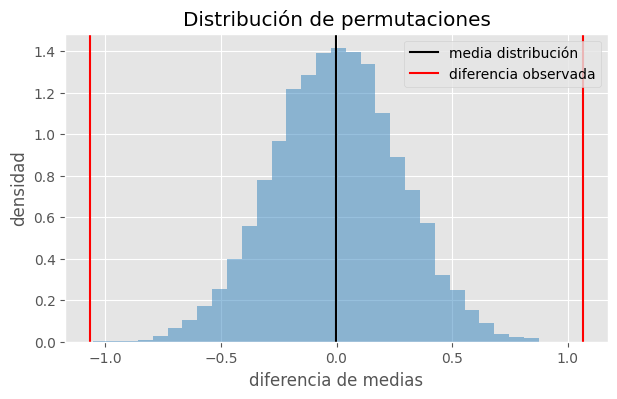

In [33]:
# Distribución de permutaciones
# ==============================================================================
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,4))
ax.hist(dist_permut, bins=30, density=True, color='#3182bd', alpha=0.5)
ax.axvline(x=dist_permut.mean(), color='black', label='media distribución')
ax.axvline(x=dif_observada, color='red', label='diferencia observada')
ax.axvline(x=-dif_observada, color='red')

ax.set_title('Distribución de permutaciones')
ax.set_xlabel('diferencia de medias')
ax.set_ylabel('densidad')
ax.legend()
plt.show()

In [34]:
pd.Series(dist_permut).describe()

count    9999.000000
mean       -0.000425
std         0.272840
min        -1.052219
25%        -0.184756
50%         0.001310
75%         0.184965
max         0.875088
dtype: float64

In [35]:
# P-value empírico con y sin corrección
# ==============================================================================
p_value = (sum(np.abs(dist_permut) > np.abs(dif_observada)))/len(dist_permut)
p_value_correc = (sum(np.abs(dist_permut) > np.abs(dif_observada)) + 1)/len(dist_permut + 1)
print(f"p-value sin corrección: {p_value.round(4)}")
print(f"p-value con corrección: {p_value_correc.round(4)}")

p-value sin corrección: 0.0
p-value con corrección: 0.0001
